In this notebook, we will run an experiment to display the average perturbation effect values that we generate with the 4 different methods we have for perturbation effect generation (other than the method for generating the perturbation effect values, we will be holding everything else the same). 

Recall that we have 4 methods for generating perturbation effect data (see `generate_in_silico_data.ipynb` for more information on these):
1. No Mean Adjustment
2. Standard Mean Adjustment
3. Mean adjustment dependent on all TFs bound to gene in question
4. Mean adjustment dependent on binary relationships between bound and unbound TFs to gene in question.

After understanding what the generated data looks like for each of these methods, we will perform another experiment where we train the same model on data generated with each of these methods and compare the model's performance to a simple linear model.

In [1]:
# imports
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the binding data will be the same as always, see `generate_in_silico_data.ipynb`

In [2]:
n_genes = 3000

signal = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, signal_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

Now we define our experiment, this function will return the average perturbation effects (across n_iterations iterations) for each TF for a specific gene for each of the 4 data generation method we have at our disposal. Due to the randomness in the generated data, we need to find the averages over a number of iterations to get the true common values.

We also need to define dictionaries of TF relationships for our third and fourth methods of generating perturbation data, see `generate_in_silico_data.ipynb` for an explanation of what these represent and how they are used / structured. The documentation in `generate_data.py` may be helpful as well.

In [3]:
tf_relationships = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

def experiment(n_iterations = 10, GENE_IDX = 0):
    print("Bound (1) and Unbound (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])

    num_tfs = sum(n_sample)
    
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    # we generate perturbation effects for each TF on each iteration and then add them to the running totals
    for i in range(n_iterations):
        # Method 1: Generate perturbation effects without mean adjustment
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(sum(n_sample))]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        # Method 2: Generate perturbation effects with normal mean adjustment
        perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_index=0, # this isn't used
            max_mean_adjustment=10.0
        )

        # Method 3: Generate perturbation effects with dependent mean adjustment
        perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_index=0,  # this isn't used
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
            max_mean_adjustment=10.0,
        )
        
        # Method 4: Generate perturbation effects with binary relations between the TFs
        perturbation_effects_list_boolean_logic = generate_perturbation_effects(
            binding_data_tensor, 
            tf_index=0,  # this isn't used
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
            max_mean_adjustment=10.0,
        )

        # take absolute values since we only care about the magnitude of the effects
        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])

        if (i + 1) % 5 == 0:
            print(f"iteration {i+1} completed")
        
    # divide by the number of iterations to get the averages
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores

Now we can run the experiment for n_iterations, I find that you should iterate at least 30 times, but closer to 100 is most ideal. This could take 1-5 minutes depending on your computer.

In [4]:
GENE_IDX = 0
experiment_results = experiment(n_iterations=50, GENE_IDX=GENE_IDX)

Bound (1) and Unbound (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
iteration 5 completed
iteration 10 completed
iteration 15 completed
iteration 20 completed
iteration 25 completed
iteration 30 completed
iteration 35 completed
iteration 40 completed
iteration 45 completed
iteration 50 completed


We now plot our results. TODO!!!!!!! add a blurb here that explains if things make sense or not and why TODO!!!!!

Bound (signal) TFs for gene 0 are: [3, 4, 5, 6, 7, 9]
Unbound (noise) TFs for gene 0 are: [0, 1, 2, 8]
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])


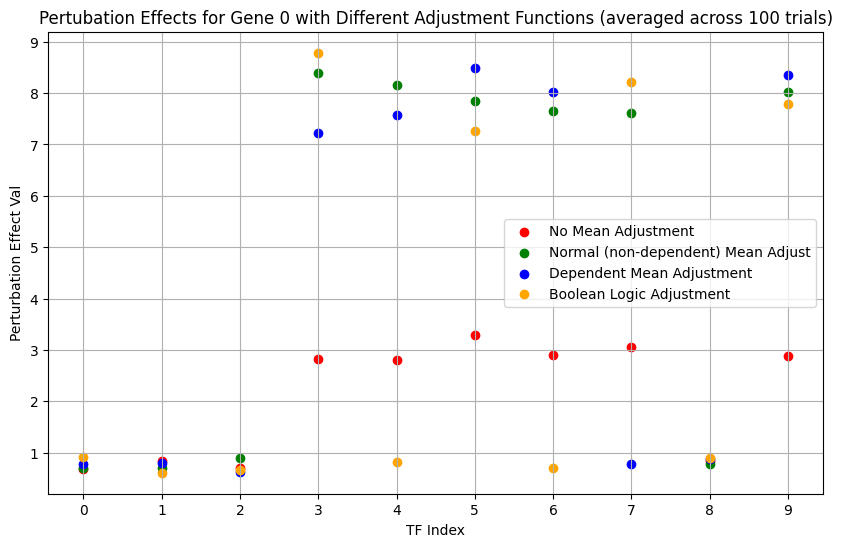

In [5]:
x_vals = list(range(sum(n_sample)))
print("Bound (signal) TFs for gene " + str(GENE_IDX) + " are: " + str(binding_data_tensor[GENE_IDX, :, 0].nonzero().flatten().tolist()))
print("Unbound (noise) TFs for gene " + str(GENE_IDX) + " are: " + str((1 - binding_data_tensor[GENE_IDX, :, 0]).nonzero().flatten().tolist()))
print(binding_data_tensor[GENE_IDX, :, 0])
plt.figure(figsize=(10, 6))

# Plot each set of experiment results with a different color
colors = ['red', 'green', 'blue', 'orange']
for index, results in enumerate(experiment_results):
    plt.scatter(x_vals, results, color=colors[index])

plt.title('Pertubation Effects for Gene ' + str(GENE_IDX) + ' with Different Adjustment Functions (averaged across 100 trials)')
plt.xlabel('TF Index')
plt.ylabel('Perturbation Effect Val')
plt.xticks(x_vals)
plt.grid(True)
plt.legend(['No Mean Adjustment', 'Normal (non-dependent) Mean Adjust', 'Dependent Mean Adjustment', 'Boolean Logic Adjustment'])
plt.show()